# T test 1

In [1]:
# I want to discuss the relation between music duration and anxiety rates. 
# The dataset is being divided into two groups based on the duration they listen to music.
# Median: 3.0 hours per day. High duration group (>3h) vs Low duration group (<3h)
# H0: The variances of the two groups are equal

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

%run parse_data.ipynb

df.describe()

,Anxiety,Age,Duration,BPM
count,624.000000,624.000000,624.000000,624.000000
mean,5.866186,24.753205,3.713462,123.214744
std,2.767640,11.709293,3.092419,32.899605
min,0.000000,10.000000,0.000000,4.000000
25%,4.000000,18.000000,2.000000,100.000000
50%,6.000000,21.000000,3.000000,120.000000
75%,8.000000,27.000000,5.000000,144.000000
max,10.000000,89.000000,24.000000,220.000000


In [3]:
median_hours = df['Duration'].median()
print(f"Median of Duration: {median_hours:.2f} hours")

df['Listening_Group_TTEST'] = np.where(
    df['Duration'] >= median_hours,
    'High_Duration',
    'Low_Duration')

print("\n--- Group Sizes ---")
print(df['Listening_Group_TTEST'].value_counts())


low_anxiety = df[df['Listening_Group_TTEST'] == 'Low_Duration']['Anxiety']
high_anxiety = df[df['Listening_Group_TTEST'] == 'High_Duration']['Anxiety']

print(f"\nMean Anxiety Score for Low_Duration (n={len(low_anxiety)}): {low_anxiety.mean():.2f}")
print(f"Mean Anxiety Score for High_Duration (n={len(high_anxiety)}): {high_anxiety.mean():.2f}")


Median of Duration: 3.00 hours

--- Group Sizes ---
Listening_Group_TTEST
High_Duration    351
Low_Duration     273
Name: count, dtype: int64

Mean Anxiety Score for Low_Duration (n=273): 5.59
Mean Anxiety Score for High_Duration (n=351): 6.08


In [4]:
# H0: The variances of the two groups are equal
levene_test = stats.levene(low_anxiety, high_anxiety)
print("\n--- Levene's Test for Homogeneity of Variances ---")
print(f"Levene's P-value: {levene_test.pvalue:.4f}")

if levene_test.pvalue > 0.05:
    t_test_result = stats.ttest_ind(low_anxiety, high_anxiety, equal_var=True)
    equal_var_status = "Equal Variance Assumed"
    
else:
    t_test_result = stats.ttest_ind(low_anxiety, high_anxiety, equal_var=False)
    equal_var_status = "Unequal Variance Assumed (Welch)"

print(f"--- Independent Samples T-test ({equal_var_status}) ---")
print(f"t Statistic: {t_test_result.statistic:.3f}")
print(f"P-value: {t_test_result.pvalue:.4f}")


--- Levene's Test for Homogeneity of Variances ---
Levene's P-value: 0.3560
--- Independent Samples T-test (Equal Variance Assumed) ---
t Statistic: -2.178
P-value: 0.0298


In [5]:
# Conclusion: The P-value (0.0298) is less than the significance level 0.05. Therefore, there is a **statistically significant difference** in the mean Anxiety scores between the two groups.

In [39]:
def display_ttest_duration_plot():
    """
    Plot Anxiety scores for Low vs High Duration groups,
    and show the t-test result in the title.
    """
    low_anxiety = df[df['Listening_Group_TTEST'] == 'Low_Duration']['Anxiety']
    high_anxiety = df[df['Listening_Group_TTEST'] == 'High_Duration']['Anxiety']

    t_result = stats.ttest_ind(low_anxiety, high_anxiety, equal_var=True)

    sns.set(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 5))

    sns.boxplot(
        data=df,
        x='Listening_Group_TTEST',
        y='Anxiety',
        order=['Low_Duration', 'High_Duration'],
        ax=ax  )

    ax.set_xlabel("Listening Duration Group (Hours/day)")
    ax.set_ylabel("Anxiety Score")

    ax.set_title(
        f"Figure 2. Anxiety by Duration Group (t-test)\n"
        f"t = {t_result.statistic:.2f}, p = {t_result.pvalue:.3f}"    )

    plt.tight_layout()
    plt.show()


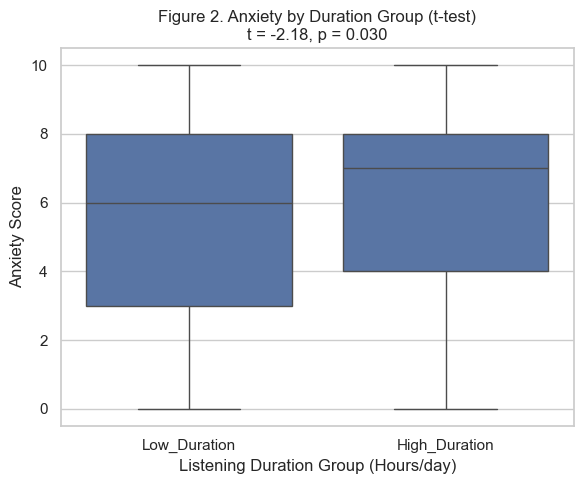

In [40]:
display_ttest_duration_plot()


# Anova 1

In [8]:
# now I want to try Anova. I'll divide the duration data into 3 groups: Low, medium and high and do futher analysing.

In [9]:
# Create 3 groups
df['Duration_Group'] = pd.qcut(df['Duration'], q=3, labels=['Low', 'Medium', 'High'])

print(df['Duration_Group'].value_counts())


Duration_Group
Low       268
Medium    187
High      169
Name: count, dtype: int64


In [10]:
df.groupby('Duration_Group', observed=True)['Anxiety'].mean()

Duration_Group
Low       5.578358
Medium    6.077540
High      6.088757
Name: Anxiety, dtype: float64

In [11]:
from scipy.stats import f_oneway

low = df[df['Duration_Group']=='Low']['Anxiety']
medium = df[df['Duration_Group']=='Medium']['Anxiety']
high = df[df['Duration_Group']=='High']['Anxiety']

anova_result = f_oneway(low, medium, high)

print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA P-value:", anova_result.pvalue)


ANOVA F-statistic: 2.553704307022989
ANOVA P-value: 0.07860970804362234


In [12]:
# p-value is bigger than 0.05, thus no significant differences were found among groups.

### Anova 2

In [13]:
# the data is divided into 4 groups, with Duration and BPM collumn both interacted. 

In [14]:
# Median split for Duration
median_duration = df['Duration'].median()
df['Duration_Group2'] = np.where(df['Duration'] >= median_duration, 'High_Duration', 'Low_Duration')

# Median split for BPM
median_bpm = df['BPM'].median()
df['BPM_Group2'] = np.where(df['BPM'] >= median_bpm, 'High_BPM', 'Low_BPM')

In [15]:
df['Interaction_Group'] = df['Duration_Group2'] + "_" + df['BPM_Group2']

print(df['Interaction_Group'].value_counts())

Interaction_Group
High_Duration_High_BPM    194
High_Duration_Low_BPM     157
Low_Duration_High_BPM     147
Low_Duration_Low_BPM      126
Name: count, dtype: int64


In [16]:
# Two-way ANOVA: Duration, BPM, and Interaction
anova_model = ols("Anxiety ~ Duration_Group2 * BPM_Group2", data=df).fit()

anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)


                                 sum_sq     df         F    PR(>F)
Duration_Group2               36.145882    1.0  4.741465  0.029820
BPM_Group2                     0.055530    1.0  0.007284  0.932013
Duration_Group2:BPM_Group2     9.426266    1.0  1.236498  0.266578
Residual                    4726.481778  620.0       NaN       NaN


In [17]:
# There was a significant main effect of Duration,
# F = 4.741465, p = 0.029820, indicating that participants who listened to music for a longer duration reported higher anxiety levels.
# However, There was no significant main effect of BPM, and the Duration * BPM interaction was also not significant.

# Anova 3

In [18]:
# The interacting groups will be changed to Duration and Age and tested again.


In [19]:
median_age = df['Age'].median()
df['Age_Group2'] = np.where(df['Age'] >= median_age, 'High_Age', 'Low_Age')
df['Age_Group2'].value_counts()

Age_Group2
High_Age    321
Low_Age     303
Name: count, dtype: int64

In [20]:
df['Dur_Age_Group'] = df['Duration_Group2'] + "_" + df['Age_Group2']
df['Dur_Age_Group'].value_counts()


Dur_Age_Group
High_Duration_Low_Age     190
High_Duration_High_Age    161
Low_Duration_High_Age     160
Low_Duration_Low_Age      113
Name: count, dtype: int64

In [21]:
model_age = ols("Anxiety ~ Duration_Group2 * Age_Group2", data=df).fit()
anova_age = sm.stats.anova_lm(model_age, typ=2)
print(anova_age)


                                 sum_sq     df         F    PR(>F)
Duration_Group2               33.194621    1.0  4.359215  0.037217
Age_Group2                     2.494196    1.0  0.327545  0.567316
Duration_Group2:Age_Group2    12.283407    1.0  1.613093  0.204534
Residual                    4721.185970  620.0       NaN       NaN


In [22]:
# According to the results, Duration still shows a great significance on influencing Anxiety, while Age and the interacting group do not show apparent correlations.

In [30]:
def _plot_interactions():
    sns.set(style="whitegrid")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    sns.pointplot(
        data=df,
        x='Duration_Group2',
        y='Anxiety',
        hue='BPM_Group2',
        dodge=True,
        markers=['o','s'],
        capsize=0.1,
        ax=axes[0]  )
    axes[0].set_title("Duration × BPM")
    axes[0].set_xlabel("Duration Group")
    axes[0].set_ylabel("Mean Anxiety")
    axes[0].legend(title="BPM Group")

    sns.pointplot(
        data=df,
        x='Duration_Group2',
        y='Anxiety',
        hue='Age_Group2',
        dodge=True,
        markers=['o','s'],
        capsize=0.1,
        ax=axes[1]
    )
    axes[1].set_title("Duration × Age")
    axes[1].set_xlabel("Duration Group")
    axes[1].set_ylabel("")
    axes[1].legend(title="Age Group")

    fig.suptitle("FIgure 3. Interaction Effects of Duration with BPM and Age on Anxiety", 
                 y=1.03, fontsize=14)

    plt.tight_layout()
    plt.show()


In [31]:

def display_interaction_plots():
    """Figure 3. Display Interaction Plots: Duration×BPM and Duration×Age"""
    _plot_interactions()

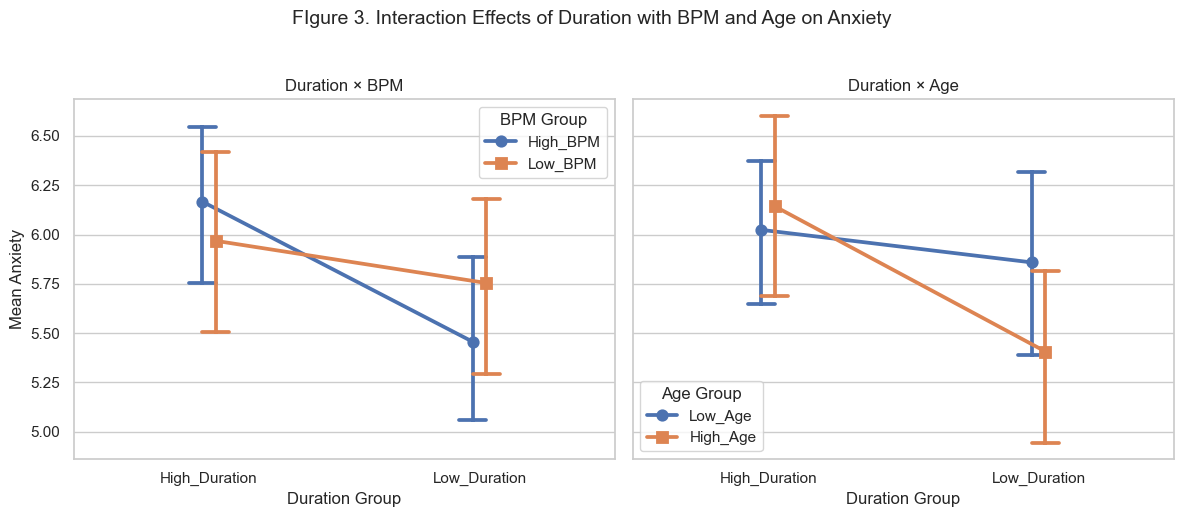

In [32]:
display_interaction_plots()
